In [1]:
import sys
import os
import pandas as pd
import numpy as np
import random
import scipy
from importlib import reload
import hypernetx as hnx
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from scipy import sparse
from sklearn.decomposition import NMF
from scipy.optimize import minimize

In [21]:
def generate_core_periphery_hypergraph(num_core_nodes, num_periphery_nodes,
                                      edge_probability_core, edge_probability_periphery,
                                      avg_edge_size, core_periphery_probability):
    """
    This function generates a random hypergraph with a core-periphery structure and creates its binary incidence matrix.

    Args:
      num_core_nodes: Number of nodes in the core.
      num_periphery_nodes: Number of nodes in the periphery.
      edge_probability_core: Probability of an edge forming between core nodes.
      edge_probability_periphery: Probability of an edge forming between periphery nodes.
      avg_edge_size: Average number of nodes per edge.
      core_periphery_probability: Probability of an edge forming between a core node and a periphery node.

    Returns:
      A tuple containing four elements:
          * core_nodes: List of core nodes.
          * periphery_nodes: List of periphery nodes.
          * edges: List of edges.
          * incidence_matrix: Binary incidence matrix as a NumPy array.
    """
    import numpy as np

    # Define core and periphery nodes
    core_nodes = list(range(num_core_nodes))
    periphery_nodes = list(range(num_core_nodes, num_core_nodes + num_periphery_nodes))

    # Get total number of nodes
    total_nodes = len(core_nodes) + len(periphery_nodes)

    # Generate edges
    edges = []
    for _ in range(int(len(core_nodes) * edge_probability_core)):
        # Sample core nodes for an edge
        edge = random.sample(core_nodes, k=int(avg_edge_size))
        edges.append(edge)

    for _ in range(int(len(periphery_nodes) * edge_probability_periphery)):
        # Sample periphery nodes for an edge
        edge = random.sample(periphery_nodes, k=int(avg_edge_size))
        edges.append(edge)

    # Add edges between core and periphery nodes
    for _ in range(int(num_core_nodes * num_periphery_nodes * core_periphery_probability)):
        # Sample a core node and a periphery node
        core_node = random.choice(core_nodes)
        periphery_node = random.choice(periphery_nodes)
        # Create an edge with the core and periphery node
        edge = [core_node, periphery_node]
        # Optionally, you can sample additional nodes for the edge
        if avg_edge_size > 2:
            additional_nodes = random.sample(core_nodes + periphery_nodes, k=int(avg_edge_size) - 2)
            edge.extend(additional_nodes)
            
        edges.append(edge)

    # Create empty matrix
    incidence_matrix = np.zeros((total_nodes, len(edges)), dtype=int)

    # Fill the matrix with 1s for corresponding nodes in each edge
    for i, edge in enumerate(edges):
        for node in edge:
            incidence_matrix[node, i] = 1

    return core_nodes, periphery_nodes, edges, incidence_matrix

# Example usage
num_core_nodes = 3
num_periphery_nodes = 5
edge_probability_core = 0.95
edge_probability_periphery = 0.2
avg_edge_size = 3
core_periphery_probability = 0.3

core_nodes, periphery_nodes, edges, incidence_matrix = generate_core_periphery_hypergraph(
    num_core_nodes, num_periphery_nodes, edge_probability_core, 
    edge_probability_periphery, avg_edge_size, core_periphery_probability)

H = pd.DataFrame(incidence_matrix)
H = H.copy().sample(frac=1)
print(f"{H.shape=}")
print(f"Min Order: {np.min(H.sum(axis=0))}")

H.shape=(8, 7)
Min Order: 2


Text(0.5, 1.0, 'H')

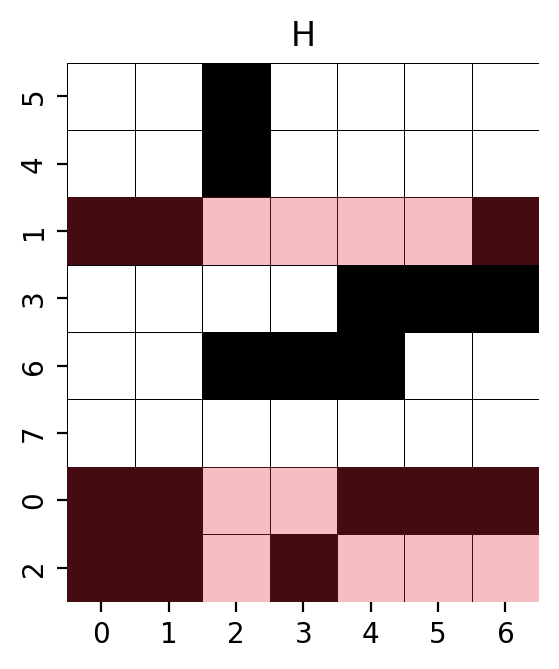

In [22]:
scale = 0.5
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = H.shape[0] * scale, H.shape[1] * scale 

sns.heatmap(
    H,
    square=True,
    cbar=False,
    cmap='binary',
    lw=0.35,
    linecolor='k',
)

ax = plt.gca()

rows_to_highlight = list(range(num_core_nodes))

# Highlight the specified rows
for row_name in rows_to_highlight:
    if row_name in H.index:
        row_index = H.index.get_loc(row_name)
        ax.axhspan(
            row_index, 
            row_index + 1, 
            facecolor='#E32636',
            alpha=0.3,
        )
        

plt.title(f"H")


Text(0.5, 0, 'Hyperedges')

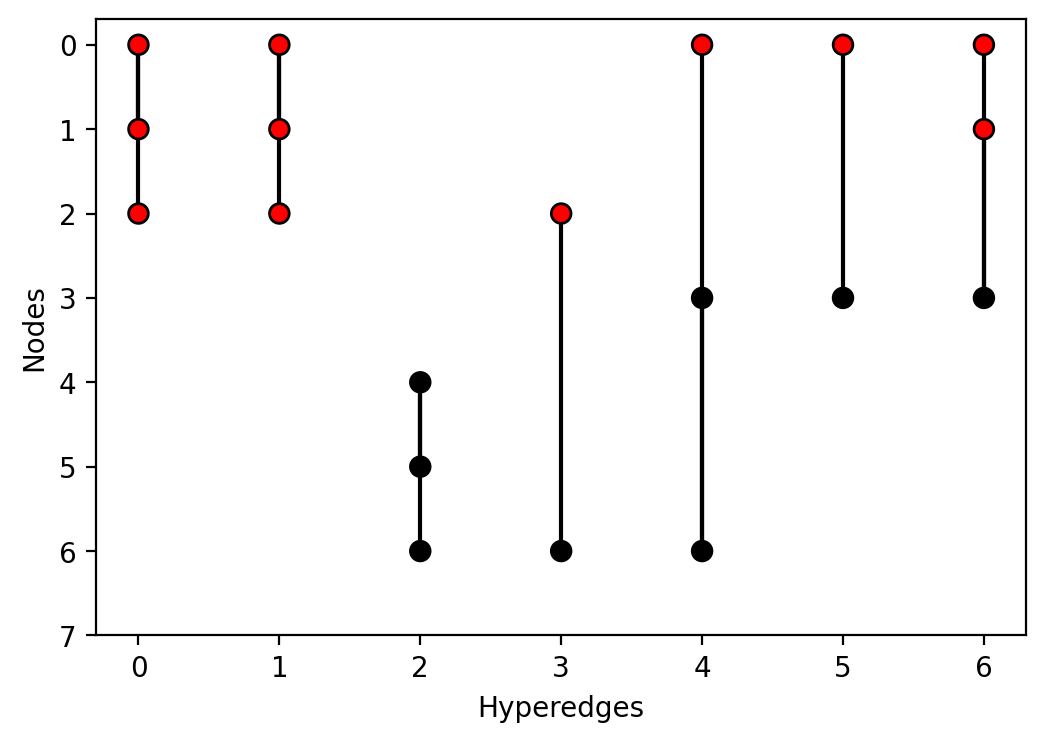

In [45]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 6, 4

for i, column in enumerate(H.columns):
    hyperedge = H[column][H[column] > 0]
    order = len(hyperedge)
    x_ind = np.ones(order) * i
    
    c = np.where(hyperedge.index.isin(core_nodes), 'r', 'k')

    # Plot nodes
    plt.scatter(x_ind, 
                hyperedge.index, 
                s=50,
                c=c, 
                ec='k',
                zorder=3)

    # Plot edges
    plt.plot(x_ind, 
             hyperedge.index,
             c='k') 
    
plt.yticks(range(H.shape[0]))
plt.gca().invert_yaxis()
plt.ylabel('Nodes')
plt.xlabel('Hyperedges')

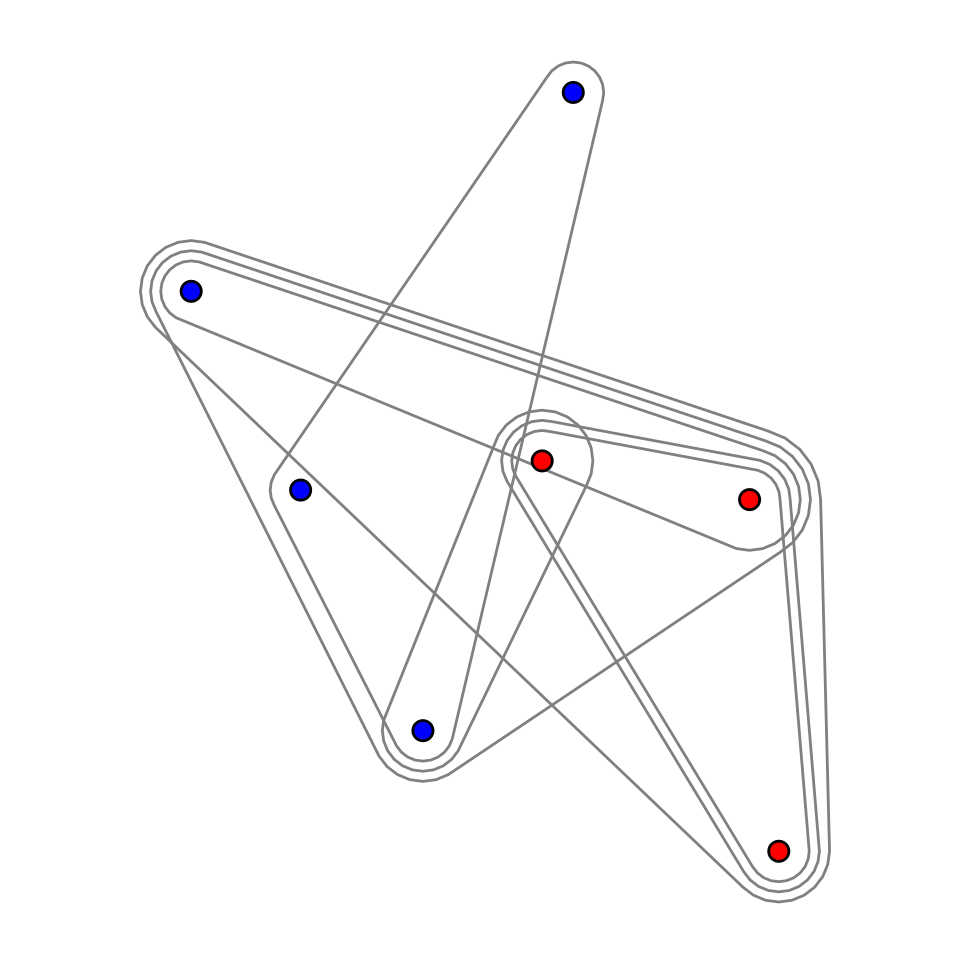

In [23]:
def to_hypernet(H):
    """A function to convert a dataframe into a 
    hypernet hypergrapgh"""
    
    iteractions = {}
    
    for idx, row in H.T.iterrows():
        iteractions[idx] = tuple(row[row == 1].index)

    hx = hnx.Hypergraph(iteractions)
    return hx
    

hx = to_hypernet(H)

def node_color(v):
    if v in core_nodes:
        return 'r'
    else:
        return 'b'

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 6, 6

hnx.drawing.draw(hx, 
                 with_node_counts=False, 
                 with_edge_counts=False,
                 with_edge_labels=False, 
                 with_node_labels=False,
                 nodes_kwargs={'color': node_color, 'edgecolor' : 'k'},
                 edges_kwargs={'edgecolors': 'grey',},
                 layout_kwargs = {'seed': 39},
                )
 

Text(0.5, 1.0, 'Rank 5 Approx of H')

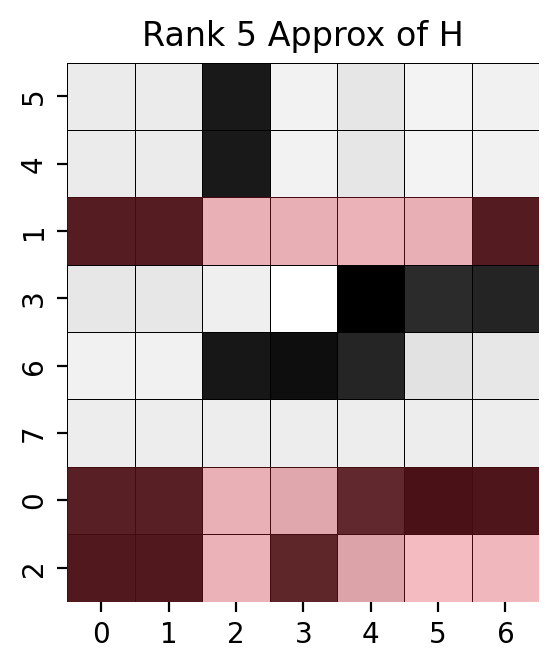

In [46]:
# H_hat is the low rank approximation 

def rank_k_approximation(H, k):
    """
    Computes a rank k approximation of a binary incidence matrix H using truncated SVD.

    Args:
        H: A binary incidence matrix (numpy array).
        k: The desired rank of the approximation.

    Returns:
        A rank k approximation of H (numpy array).
    """

    # Perform SVD on H
    U, S, Vh = np.linalg.svd(H, full_matrices=False)

    # Truncate U, S, and Vh to keep only the first k singular values and vectors
    Uk = U[:, :k]
    Sk = np.diag(S[:k])
    Vhk = Vh[:k, :]

    # Reconstruct the matrix using the truncated components
    H_approx = Uk @ Sk @ Vhk
    return H_approx


def shift_matrix_to_non_negative(matrix):
    """
    Shifts a matrix so that its minimum value becomes 0.

    Args:
    matrix: A NumPy array representing the matrix.

    Returns:
    The shifted matrix, where all values are non-negative.
    """

    min_val = np.min(matrix)  # Find the minimum value in the matrix

    # If the minimum value is already 0 or positive, no shift is needed
    if min_val >= 0:
        return matrix 
    else:
        # Shift all values up by the absolute value of the minimum 
        shifted_matrix = matrix + abs(min_val)
        return shifted_matrix

rank = 5
H_hat = rank_k_approximation(H, k=rank)
H_hat = pd.DataFrame(H_hat, index=H.index)
# H_hat_nn = shift_matrix_to_non_negative(H_hat)
# H_hat_nn = pd.DataFrame(H_hat_nn, index=H.index)

scale = 0.5
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = H.shape[0] * scale, H.shape[1] * scale 

sns.heatmap(
    H_hat,
    square=True,
    cbar=False,
    cmap='binary',
    lw=0.35,
    linecolor='k',
)

ax = plt.gca()

rows_to_highlight = list(range(num_core_nodes))

# Highlight the specified rows
for row_name in rows_to_highlight:
    if row_name in H.index:
        row_index = H.index.get_loc(row_name)
        ax.axhspan(
            row_index, 
            row_index + 1, 
            facecolor='#E32636',
            alpha=0.3,
        )
        

plt.title(f"Rank {rank} Approx of H")

In [47]:
np.linalg.matrix_rank(H_hat)

5

In [48]:
H_hat

,0,1,2,3,4,5,6
5,0.008536,0.008536,0.997235,-0.024562,0.032608,-0.026143,-0.016176
4,0.008536,0.008536,0.997235,-0.024562,0.032608,-0.026143,-0.016176
1,0.997234,0.997234,0.000896,0.007959,-0.010567,0.008472,1.005242
3,0.029979,0.029979,-0.009711,-0.086262,1.114522,0.908183,0.943189
6,-0.016305,-0.016305,1.005282,1.046915,0.937715,0.049936,0.030898
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0,0.977276,0.977276,0.007361,0.065385,0.913194,1.069596,1.043062
2,1.023121,1.023121,-0.007490,0.933472,0.088324,-0.070813,-0.043815


# Direct solution

M.shape=(8, 8)


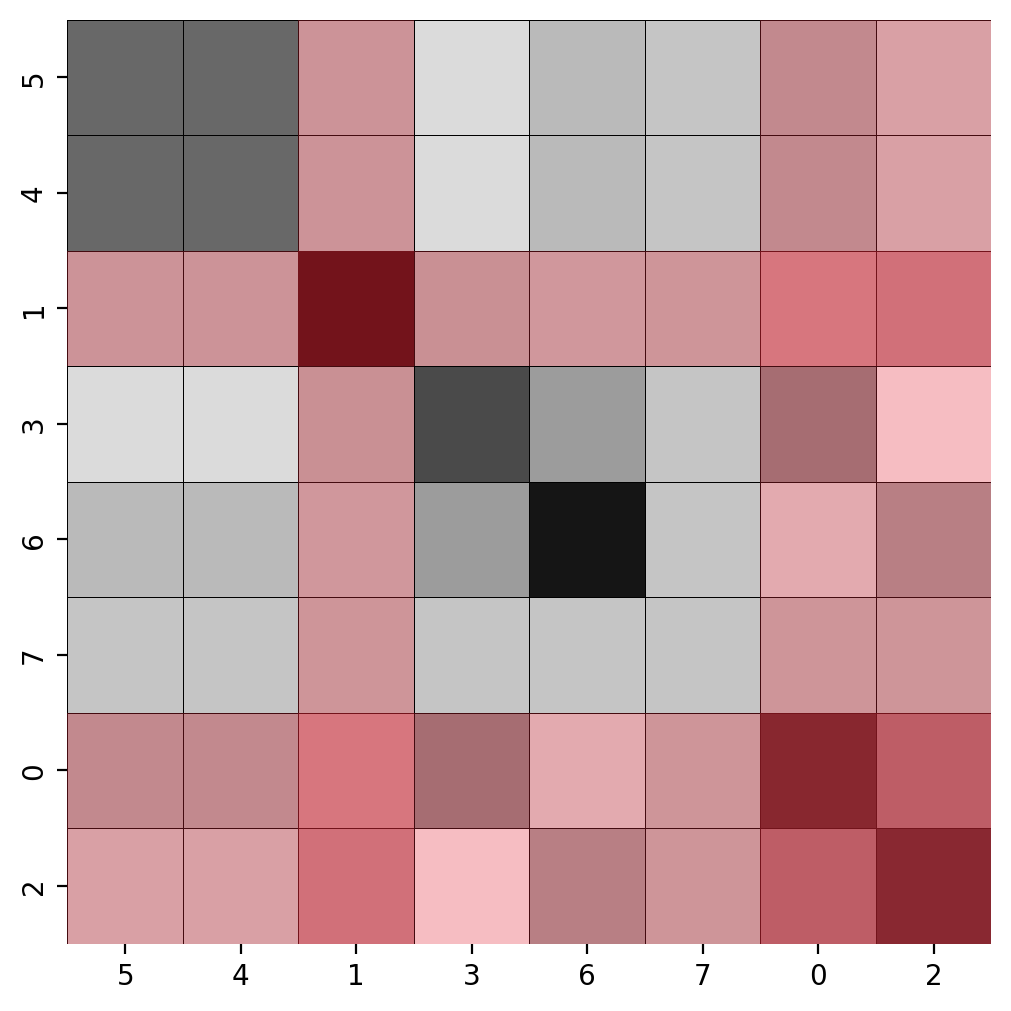

In [49]:
M = np.dot(H_hat, np.linalg.pinv(H))
M = pd.DataFrame(M, index=H.index, columns=H.index)
print(f"{M.shape=}")


plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 6, 6

sns.heatmap(
    M,
    square=True,
    cbar=False,
    cmap='binary',
    lw=0.35,
    linecolor='k',
)

ax = plt.gca()

rows_to_highlight = list(range(num_core_nodes))

# Highlight the specified rows
for row_name in rows_to_highlight:
    if row_name in H.index:
        row_index = H.index.get_loc(row_name)
        ax.axhspan(
            row_index, 
            row_index + 1, 
            facecolor='#E32636',
            alpha=0.3,
        )
        
        ax.axvspan(
            row_index, 
            row_index + 1, 
            facecolor='#E32636',
            alpha=0.3,
        )

In [7]:
H

,0,1,2,3,4,5,6,7,8,9,10
4,0,0,0,1,0,0,0,0,0,0,1
1,1,1,0,0,0,0,0,1,1,1,1
0,1,1,0,0,1,1,1,0,0,0,1
2,1,1,0,0,0,0,0,1,1,0,0
5,0,0,1,1,1,0,0,1,0,1,0
7,0,0,1,1,0,1,0,0,0,0,0
6,0,0,0,0,0,1,0,0,1,0,0
3,0,0,1,0,0,0,1,0,0,0,0


In [8]:
np.min(M)

-0.1924009689640945

In [9]:
M

,4,1,0,2,5,7,6,3
4,0.065440,0.011265,0.102021,-0.016433,0.153693,0.141272,0.023010,0.079018
1,0.011265,0.550528,0.085239,0.436573,0.160271,-0.114806,0.054970,-0.087001
0,0.102021,0.085239,0.808630,0.053106,-0.192401,0.169981,0.193893,0.175348
2,-0.016433,0.436573,0.053106,0.357011,0.051438,-0.148175,0.040879,-0.097953
5,0.153693,0.160271,-0.192401,0.051438,0.707325,0.321006,-0.039643,0.115877
7,0.141272,-0.114806,0.169981,-0.148175,0.321006,0.341967,0.028907,0.192763
6,0.023010,0.054970,0.193893,0.040879,-0.039643,0.028907,0.048735,0.033709
3,0.079018,-0.087001,0.175348,-0.097953,0.115877,0.192763,0.033709,0.120363


In [50]:
def solve_for_binary_M(H, Q):
    """
    Solves the matrix equation MH = Q for M, where M is binary and has column sums equal to 1.

    Args:
        H: A rectangular matrix.
        Q: A rectangular matrix with the same shape as H.

    Returns:
        M: The binary matrix solution, if found. Otherwise, None.
    """

    num_rows_M = Q.shape[0]
    num_cols_M = H.shape[0]

    def objective(x):
        M = x.reshape(num_rows_M, num_cols_M)
        return np.linalg.norm(np.dot(M, H) - Q)

    constraints = [
        {'type': 'eq', 'fun': lambda x: np.sum(x.reshape(num_rows_M, num_cols_M), axis=0) - 1},
    ]
    bounds = [(0, 1) for _ in range(num_rows_M * num_cols_M)]

    x0 = np.zeros(num_rows_M * num_cols_M)

    result = minimize(objective, x0, constraints=constraints, bounds=bounds)

    if result.success:
        M = result.x.reshape(num_rows_M, num_cols_M)
        M = np.round(M)  # Ensure strict binary values
        return M
    else:
        print("No feasible solution found.")
        return None
    
    
newM = solve_for_binary_M(H, H_hat)

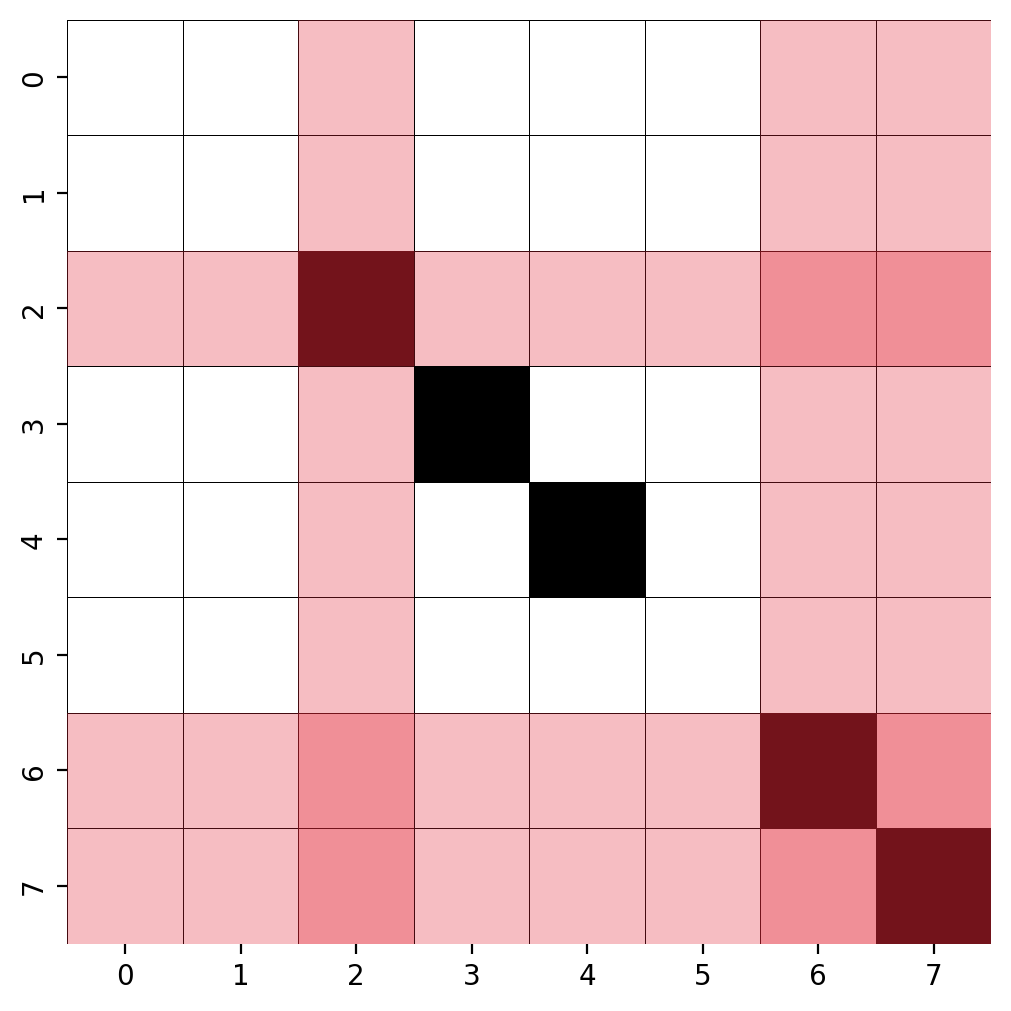

In [51]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 6, 6

sns.heatmap(
    newM,
    square=True,
    cbar=False,
    cmap='binary',
    lw=0.35,
    linecolor='k',
)

ax = plt.gca()

rows_to_highlight = list(range(num_core_nodes))

# Highlight the specified rows
for row_name in rows_to_highlight:
    if row_name in H.index:
        row_index = H.index.get_loc(row_name)
        ax.axhspan(
            row_index, 
            row_index + 1, 
            facecolor='#E32636',
            alpha=0.3,
        )
        
        ax.axvspan(
            row_index, 
            row_index + 1, 
            facecolor='#E32636',
            alpha=0.3,
        )

In [52]:
type(H)

pandas.core.frame.DataFrame

Text(0.5, 0, 'Hyperedges')

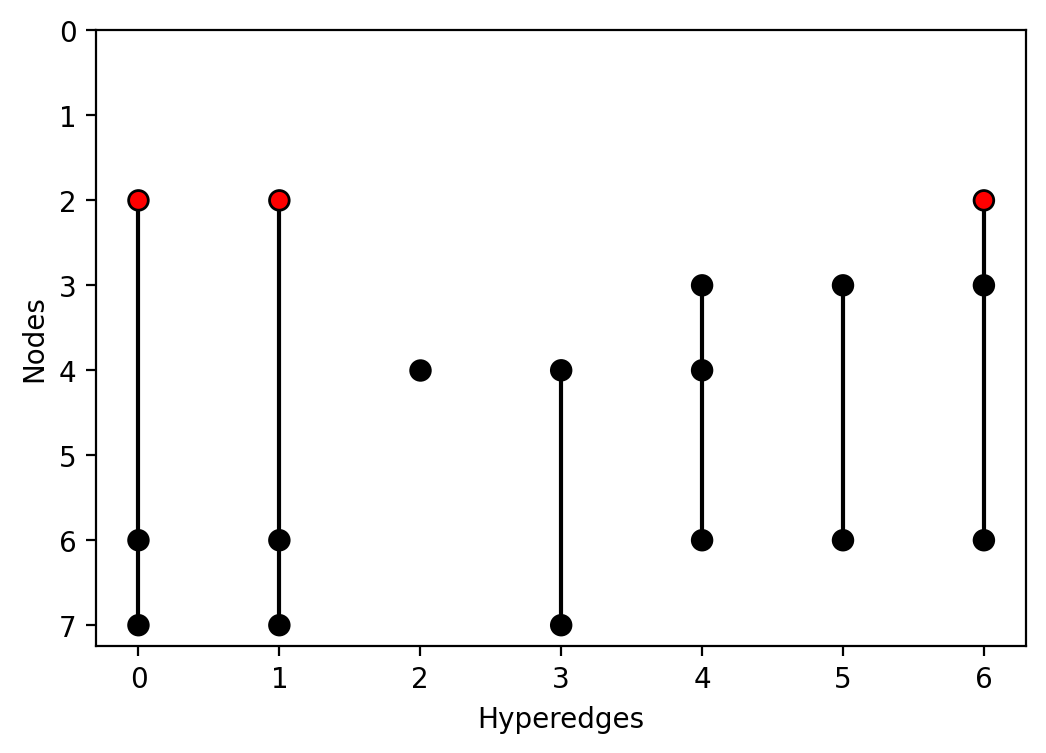

In [53]:
postH = pd.DataFrame(newM.dot(H))
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 6, 4

for i, column in enumerate(postH.columns):
    hyperedge = postH[column][postH[column] > 0]
    order = len(hyperedge)
    x_ind = np.ones(order) * i
    
    c = np.where(hyperedge.index.isin(core_nodes), 'r', 'k')

    # Plot nodes
    plt.scatter(x_ind, 
                hyperedge.index, 
                s=50,
                c=c, 
                ec='k',
                zorder=3)

    # Plot edges
    plt.plot(x_ind, 
             hyperedge.index,
             c='k') 
    
plt.yticks(range(postH.shape[0]))
plt.gca().invert_yaxis()
plt.ylabel('Nodes')
plt.xlabel('Hyperedges')


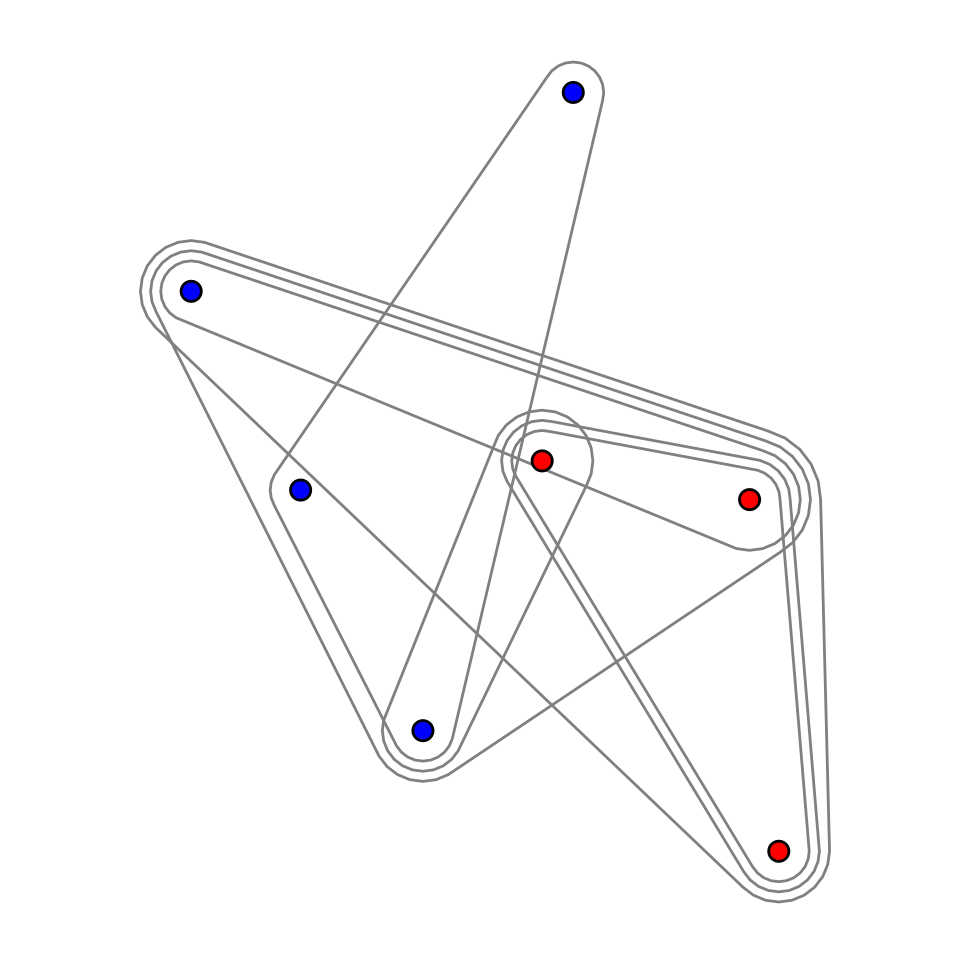

In [29]:
def to_hypernet(H):
    """A function to convert a dataframe into a 
    hypernet hypergrapgh"""
    
    iteractions = {}
    
    for idx, row in H.T.iterrows():
        iteractions[idx] = tuple(row[row == 1].index)

    hx = hnx.Hypergraph(iteractions)
    return hx
    

hx = to_hypernet(H)

def node_color(v):
    if v in core_nodes:
        return 'r'
    else:
        return 'b'

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 6, 6

hnx.drawing.draw(hx, 
                 with_node_counts=False, 
                 with_edge_counts=False,
                 with_edge_labels=False, 
                 with_node_labels=False,
                 nodes_kwargs={'color': node_color, 'edgecolor' : 'k'},
                 edges_kwargs={'edgecolors': 'grey',},
                 layout_kwargs = {'seed': 39},
                )
 

<Axes: >

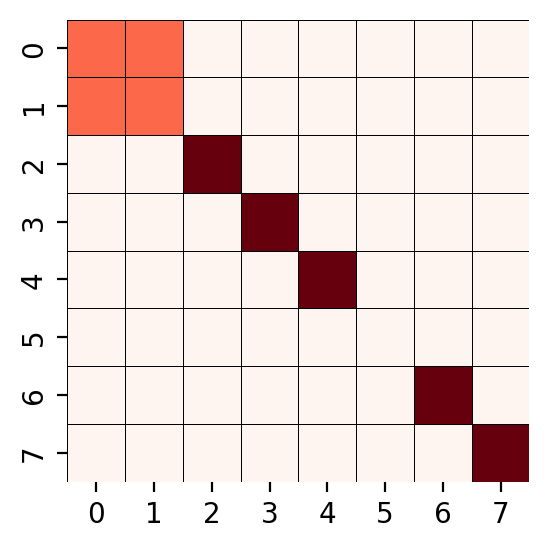

In [54]:
M_approx = np.dot(H, np.linalg.pinv(H))

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3, 3

sns.heatmap(
    M_approx,
    square=True,
    cbar=False,
    cmap='Reds',
    lw=0.35,
    linecolor='k',
) 

<Axes: >

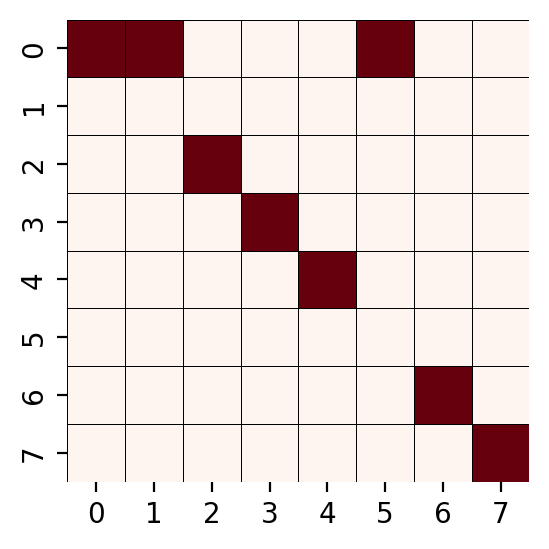

In [55]:
M_bin = np.zeros(M_approx.shape)

max_column = M_approx.argmax(axis=0)

for i, j in zip(range(len(max_column)), max_column):
    M_bin[i, j] = 1
    
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3, 3
    
sns.heatmap(
    M_bin.T,
    square=True,
    cbar=False,
    cmap='Reds',
    lw=0.35,
    linecolor='k',
) 

In [57]:
M_bin.T

array([[1., 1., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.]])

In [58]:
projected_core = np.dot(M_bin.T, H)
projected_core
sum(np.isin(projected_core, range(2, M_bin.shape[0])))

array([0, 0, 1, 0, 0, 0, 0])

<class 'hypernetx.classes.hypergraph.Hypergraph'>


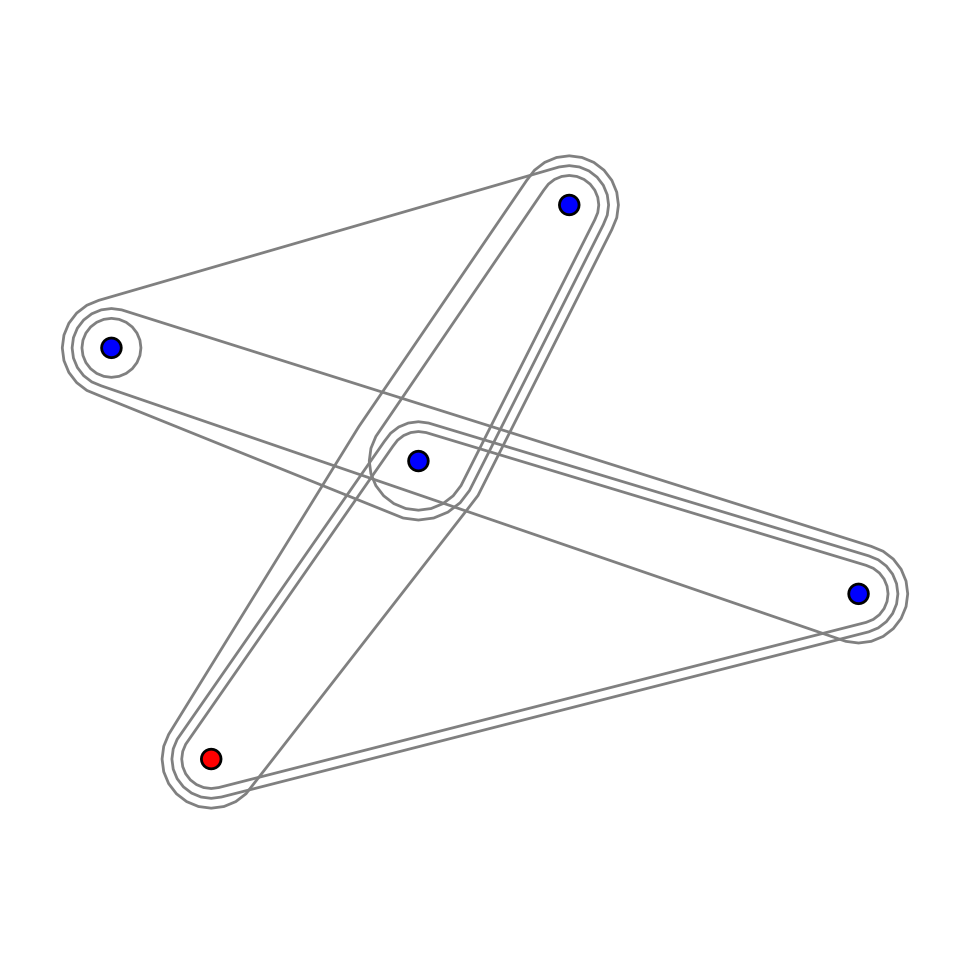

In [59]:
p_core = to_hypernet(pd.DataFrame(projected_core))

print(type(p_core))
def node_color(v):
    if v in core_nodes:
        return 'r'
    else:
        return 'b'

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 6, 6

hnx.drawing.draw(p_core, 
                 with_node_counts=False, 
                 with_edge_counts=False,
                 with_edge_labels=False, 
                 with_node_labels=False,
                 nodes_kwargs={'color': node_color, 'edgecolor' : 'k'},
                 edges_kwargs={'edgecolors': 'grey',},
                 layout_kwargs = {'seed': 39},
                )
 

In [18]:
def edge_check(arr1, arr2):
    # Ensure arr1 and arr2 are numpy arrays
    arr1 = np.array(arr1)
    arr2 = np.array(arr2)
    
    # Get the number of columns in both arrays
    num_cols1 = arr1.shape[1]
    num_cols2 = arr2.shape[1]
    
    # Convert columns to tuples for easy comparison
    cols1 = {tuple(arr1[:, i]) for i in range(num_cols1)}
    cols2 = {tuple(arr2[:, i]) for i in range(num_cols2)}
    
    # Check if each column in arr1 is in arr2
    result = [col in cols2 for col in cols1]
    
    return result

In [34]:
edge_check(projected_core, H)

[False, True, False, True, False, True]

In [20]:
def find_M_NMF(H, H_approx, k): 
    """
    Attempts to find a binary matrix M using NMF, where MH ≈ H_approx
    and M has column sums equal to 1.
    """

    # 1. Perform NMF on H_approx
    model = NMF(n_components=k, init='random', random_state=0)
    W = model.fit_transform(H_approx)
    H_nmf = model.components_
    
    
    

    # 2. Attempt to construct M from W and H, ensuring correct dimensions
    M = np.zeros((W.shape[0], H.shape[0]))  # M's shape should be (num_components, num_cols_in_H)

    for col_idx in range(H.shape[0]):
        similarities = np.dot(W.T, H.to_numpy()[:, col_idx])
        best_row_idx = np.argmax(similarities)
        M[best_row_idx, col_idx] = 1

    # 3. Enforce column sums == 1 
    for col_idx in range(M.shape[1]):
        if np.sum(M[:, col_idx]) == 0:
            M[np.random.randint(M.shape[0]), col_idx] = 1
        elif np.sum(M[:, col_idx]) > 1:
            indices_of_ones = np.where(M[:, col_idx] == 1)[0]
            M[np.random.choice(indices_of_ones, size=len(indices_of_ones)-1, replace=False), col_idx] = 0

    return M

# Assuming you have H and H_hat_nn defined elsewhere
M = find_M_NMF(H, H_hat_nn, k=rank)
print(M.shape) 


M = find_M_NMF(H, H_hat_nn, k=7)
print(f"{M.shape=}")

sns.heatmap(
    M,
    square=True,
    cbar=False,
    cmap='Blues',
    lw=0.35,
    linecolor='k',
)

plt.title(f"Rank {rank} Approx of H")

NameError: name 'H_hat_nn' is not defined

In [ ]:
np.dot(M, H)

In [ ]:

sns.heatmap(
    np.dot(M, Ha
    square=True,
    cbar=False,
    cmap='Reds',
    lw=0.35,
    linecolor='k',
)
